In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import random
from termcolor import colored
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal

c:\Users\vcc\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_width, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.l1 = nn.Linear(state_dim, hidden_width)
        self.l2 = nn.Linear(hidden_width, hidden_width)
        self.l3 = nn.Linear(hidden_width, action_dim)

    def forward(self, s):
        s = F.relu(self.l1(s))
        s = F.relu(self.l2(s))
        a = self.max_action * torch.tanh(self.l3(s)) 
        return a


class Critic(nn.Module):  # According to (s,a), directly calculate Q(s,a)
    def __init__(self, state_dim, action_dim, hidden_width):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, hidden_width)
        self.l2 = nn.Linear(hidden_width, hidden_width)
        self.l3 = nn.Linear(hidden_width, 1)

    def forward(self, s, a):
        q = F.relu(self.l1(torch.cat([s, a], 1)))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q

In [4]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim):
        self.max_size = int(1e6)
        self.count = 0
        self.size = 0
        self.s = np.zeros((self.max_size, state_dim))
        self.a = np.zeros((self.max_size, action_dim))
        self.r = np.zeros((self.max_size, 1))
        self.s_ = np.zeros((self.max_size, state_dim))
        self.dw = np.zeros((self.max_size, 1))

    def store(self, s, a, r, s_, dw):
        self.s[self.count] = s
        self.a[self.count] = a
        self.r[self.count] = r
        self.s_[self.count] = s_
        self.dw[self.count] = dw
        self.count = (self.count + 1) % self.max_size  # When the 'count' reaches max_size, it will be reset to 0.
        self.size = min(self.size + 1, self.max_size)  # Record the number of  transitions

    def sample(self, batch_size):
        index = np.random.choice(self.size, size=batch_size)  # Randomly sampling
        batch_s = torch.tensor(self.s[index], dtype=torch.float)
        batch_a = torch.tensor(self.a[index], dtype=torch.float)
        batch_r = torch.tensor(self.r[index], dtype=torch.float)
        batch_s_ = torch.tensor(self.s_[index], dtype=torch.float)
        batch_dw = torch.tensor(self.dw[index], dtype=torch.float)

        return batch_s, batch_a, batch_r, batch_s_, batch_dw

In [5]:
class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action):
        self.hidden_width = 256  # The number of neurons in hidden layers of the neural network
        self.batch_size = 256  # batch size
        self.GAMMA = 0.99  # discount factor
        self.TAU = 0.005  # Softly update the target network
        self.lr = 3e-4  # learning rate

        self.actor = Actor(state_dim, action_dim, self.hidden_width, max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic = Critic(state_dim, action_dim, self.hidden_width)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

        self.MseLoss = nn.MSELoss()

    def choose_action(self, s):
        s = torch.unsqueeze(torch.tensor(s, dtype=torch.float), 0)
        a = self.actor(s).data.numpy().flatten()
        return a

    def learn(self, relay_buffer):
        batch_s, batch_a, batch_r, batch_s_, batch_dw = relay_buffer.sample(self.batch_size)  # Sample a batch

        # Compute the target Q
        with torch.no_grad():  # target_Q has no gradient
            Q_ = self.critic_target(batch_s_, self.actor_target(batch_s_))
            target_Q = batch_r + self.GAMMA * (1 - batch_dw) * Q_

        # Compute the current Q and the critic loss
        current_Q = self.critic(batch_s, batch_a)
        critic_loss = self.MseLoss(target_Q, current_Q)
        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Freeze critic networks so you don't waste computational effort
        for params in self.critic.parameters():
            params.requires_grad = False

        # Compute the actor loss
        actor_loss = -self.critic(batch_s, self.actor(batch_s)).mean()
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Unfreeze critic networks
        for params in self.critic.parameters():
            params.requires_grad = True

        # Softly update the target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

In [6]:
def evaluate_policy(env, agent):
    times = 3  # Perform three evaluations and calculate the average
    evaluate_reward = 0
    for _ in range(times):
        s = env.reset()
        done = False
        episode_reward = 0
        while not done:
            a = agent.choose_action(s)  # We do not add noise when evaluating
            s_, r, done, _ = env.step(a)
            episode_reward += r
            s = s_
        evaluate_reward += episode_reward

    return int(evaluate_reward / times)

In [7]:
def reward_adapter(r, env_index):
    if env_index == 0:  # Pendulum-v1
        r = (r + 8)/5
    elif env_index == 1:  # BipedalWalker-v3
        if r <= -100:
            r = -1
    return r

In [8]:
BOARD_ROWS = 10
BOARD_COLS = 10
WIN_STATE = (0, 9)
LOSE_STATE = (1, 9)
obstacles = [(2,0), (4,1), (1,2), (6,2), (2,4), (3,4), (4,4), (5,4), (6,4), 
             (7,4), (3,5), (9,5), (1,6), (6,6), (0,7), (6,7), (3,8), (6,8), (4,9)
            ]

In [9]:
class Environment:
    def __init__(self, BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE,
                 obstacles, DETERMINISTIC = True):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[LOSE_STATE] = -99
        self.board[WIN_STATE] = 99
        for i,j in obstacles:
            self.board[i,j] = -1
            
        while True:
            a = random.randint(0, BOARD_ROWS-1)
            b = random.randint(0, BOARD_COLS-1)
            if (a,b) not in obstacles and (a,b) != WIN_STATE and (a,b) != LOSE_STATE:
                START = (a,b)
                break    
                
        START = (9,0)        
            
        self.state = START
        self.win_state = WIN_STATE
        self.lose_state = LOSE_STATE
        self.obstacles = obstacles
        self.n_rows = BOARD_ROWS
        self.n_cols = BOARD_COLS
        self.isEnd = False
        self.determine = DETERMINISTIC
        

    def giveReward(self, obs_flag=False):
        if self.state == self.win_state:
            return 2000
        elif self.state == self.lose_state:
            return -2
        elif obs_flag == True:
            return -1
        else:
            return -0.1

    def isEndFunc(self):
        if (self.state == self.win_state) or (self.state == self.lose_state):
            self.isEnd = True

    def step(self, action):
        if self.determine:
            if action == 0: # N
                nxtState = (self.state[0] - 1, self.state[1])
            elif action == 1: # S
                nxtState = (self.state[0] + 1, self.state[1])
            elif action == 2: # W
                nxtState = (self.state[0], self.state[1] - 1)
            elif action == 3: # E
                nxtState = (self.state[0], self.state[1] + 1)
            elif action == 4: # NE
                nxtState = (self.state[0] - 1, self.state[1] + 1)
            elif action == 5: # NW
                nxtState = (self.state[0] - 1, self.state[1] - 1)
            elif action == 6: # SE
                nxtState = (self.state[0] + 1, self.state[1] + 1)
            elif action == 7: # SW
                nxtState = (self.state[0] + 1, self.state[1] - 1)    
        
            # if next state legal
            if (nxtState[0] >= 0) and (nxtState[0] <= (self.n_rows -1)):
                if (nxtState[1] >= 0) and (nxtState[1] <= (self.n_cols -1)):
                    if nxtState in self.obstacles:
                        self.isEndFunc()
                        r = self.giveReward(obs_flag=True)
                        return self.state, r, self.isEnd
                    else:
                        self.state = nxtState          
                        self.isEndFunc()
                        r = self.giveReward()
                        return self.state, r, self.isEnd
                    
            return self.state, -1, self.isEnd       
                        
    def reset(self):
        while True:
            a = random.randint(0, self.n_rows-1)
            b = random.randint(0, self.n_cols-1)
            if (a,b) not in obstacles and (a,b) != self.win_state and (a,b) != self.lose_state:
                self.state = (a,b)
                #self.state = (9,0)
                self.isEnd = False
                break
        return self.state    
    
    def get_all_states(self):
        all_states = []
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                all_states.append((i,j))
                
        return all_states        
    
    def get_all_actions(self):
        all_actions = [0, 1, 2, 3, 4, 5, 6, 7]
        return all_actions

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, self.n_rows):
            print('----------------------------------')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = colored('\033[1m' +'*', 'red')
                if self.board[i, j] == -1:
                    token = 'W'
                if self.board[i, j] == 0:
                    token = '-'
                if self.board[i, j] == -99:
                    token = 'P'    
                if self.board[i, j] == 99:
                    token = colored('\033[1m' +'G', 'green')     
                out += token + ' | '
            print(out)
        print('----------------------------------')

In [10]:
env = Environment(BOARD_ROWS, BOARD_COLS, WIN_STATE, LOSE_STATE, obstacles)

In [11]:
env.showBoard()

----------------------------------
| - | - | - | - | - | - | - | W | - | G | 
----------------------------------
| - | - | W | - | - | - | W | - | - | P | 
----------------------------------
| W | - | - | - | W | - | - | - | - | - | 
----------------------------------
| - | - | - | - | W | W | - | - | W | - | 
----------------------------------
| - | W | - | - | W | - | - | - | - | W | 
----------------------------------
| - | - | - | - | W | - | - | - | - | - | 
----------------------------------
| - | - | W | - | W | - | W | W | W | - | 
----------------------------------
| - | - | - | - | W | - | - | - | - | - | 
----------------------------------
| - | - | - | - | - | - | - | - | - | - | 
----------------------------------
| * | - | - | - | - | W | - | - | - | - | 
----------------------------------


# DDPG (discrete actions)

In [12]:
def q_learning(env, eps, alpha, gamma, n_episodes):
    all_states = env.get_all_states()
    all_actions = env.get_all_actions()
    Q_table = np.zeros((env.n_rows, env.n_cols, len(all_actions)))
    for x,y in all_states:
        for a in all_actions:
            if (x,y) != env.win_state:
                Q_table[x,y,a] = np.random.normal()
            else:
                Q_table[x,y,a] = 0
                
    rewards_hist = []   
    env_index = 0
    random_steps = 1  # Take the random actions in the beginning for the better exploration
    update_freq = 5  # Take 50 steps,then update the networks 50 times


    agent = DDPG(2,1,1)
    replay_buffer1 = ReplayBuffer(2, 1)
    replay_buffer = ReplayBuffer(2, 1)
    p = 0
    n = 0
    win = 0 
 
    for episode in range(n_episodes):
        
        s = env.reset()
        #s = (0,8)
        #s = (0,9)
        all_rewards = 0
        counter = 0
        done = False

        while not done:

            if episode < random_steps:
                list_actions = [0, 1, 2, 3, 4, 5, 6, 7]
                a = random.choice(list_actions)
          
            else:    
                a2 = agent.choose_action(s)
                a = a2[0]
            
                if -1 <= a <= -0.75:
                    a=0
                if -0.75 < a <= -0.5:
                    a=1
                if -0.5 < a <= -0.25:
                    a=2
                if -0.25 < a <= 0:
                    a=3             
                if 0 < a <= 0.25:
                    a=4
                if 0.25 < a <= 0.5:
                    a=5
                if 0.5 < a <= 0.75:
                    a=6 
                if 0.75 < a <= 1:
                    a=7       

            counter = counter + 1

            next_state, r, done = env.step(a)
            r = reward_adapter(r, env_index)
            all_rewards += r
            
            if done and episode != n_episodes:
                dw = True
            else:
                dw = False
            
            if a == 0:
                act = -0.88
            if a == 1:
                act = -0.63
            if a == 2:
                act = -0.33
            if a == 3:
                act = -0.12
            if a == 4:
                act = 0.12
            if a == 5:
                act = 0.33
            if a == 6:
                act = 0.63
            if a == 7:
                act = 0.88

            replay_buffer.store(s, act, r, next_state, dw)  # Store the transition
            s = next_state

            #if done:
                #win = win + 1
                #batch_s, batch_a, batch_r, batch_s_, batch_dw = replay_buffer1.sample(win)  # Sample a batch
                #replay_buffer.store(batch_s, batch_a, batch_r, batch_s_, batch_dw)  # Store the transition

    

            if episode >= random_steps and episode % update_freq == 0:
                for _ in range(update_freq):
                    agent.learn(replay_buffer)
            
            #print("state is:", s)

            if  done:
                rewards_hist.append(all_rewards)
                #print("rewards:", all_rewards)
                break

            elif  episode >= random_steps and counter == 200:
                rewards_hist.append(all_rewards)
                #print("rewards:", all_rewards)
                break
                

        eps *= 0.99       
                
    return a, Q_table, rewards_hist             

In [ ]:
_,Q,rewads_hist2 = q_learning(env, 0.99, 0.1, 0.9, 6000)

In [124]:
window = []
for i in range (len(rewads_hist2)):
    window.append(sum(rewads_hist2[i:i+101]) / len(rewads_hist2[i:i+101]))

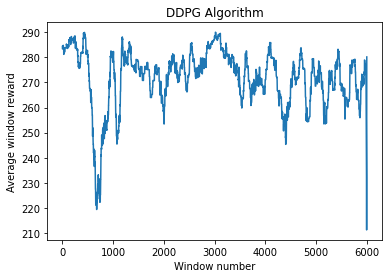

In [125]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('DDPG Algorithm');

# DDPG(discrete actions)

slippery

false action prob = 0.1

In [13]:
def q_learning(env, eps, alpha, gamma, n_episodes):
    all_states = env.get_all_states()
    all_actions = env.get_all_actions()
    Q_table = np.zeros((env.n_rows, env.n_cols, len(all_actions)))
    for x,y in all_states:
        for a in all_actions:
            if (x,y) != env.win_state:
                Q_table[x,y,a] = np.random.normal()
            else:
                Q_table[x,y,a] = 0
                
    rewards_hist = []   
    env_index = 0
    random_steps = 1  # Take the random actions in the beginning for the better exploration
    update_freq = 5  # Take 50 steps,then update the networks 50 times


    agent = DDPG(2,1,1)
    replay_buffer1 = ReplayBuffer(2, 1)
    replay_buffer = ReplayBuffer(2, 1)
    p = 0
    n = 0
    win = 0 
 
    for episode in range(n_episodes):
        
        s = env.reset()
        #s = (0,8)
        #s = (0,9)
        all_rewards = 0
        counter = 0
        done = False

        while not done:

            if episode < random_steps:
                list_actions = [0, 1, 2, 3, 4, 5, 6, 7]
                a = random.choice(list_actions)
          
            else:    
                a2 = agent.choose_action(s)
                a = a2[0]
            
                if -1 <= a <= -0.75:
                    a=0
                if -0.75 < a <= -0.5:
                    a=1
                if -0.5 < a <= -0.25:
                    a=2
                if -0.25 < a <= 0:
                    a=3             
                if 0 < a <= 0.25:
                    a=4
                if 0.25 < a <= 0.5:
                    a=5
                if 0.5 < a <= 0.75:
                    a=6 
                if 0.75 < a <= 1:
                    a=7       
            
            if random.uniform(0,1) > 0.9:
                a = random.choice(all_actions)
            
            counter = counter + 1

            next_state, r, done = env.step(a)
            r = reward_adapter(r, env_index)
            all_rewards += r
            
            if done and episode != n_episodes:
                dw = True
            else:
                dw = False
            
            if a == 0:
                act = -0.88
            if a == 1:
                act = -0.63
            if a == 2:
                act = -0.33
            if a == 3:
                act = -0.12
            if a == 4:
                act = 0.12
            if a == 5:
                act = 0.33
            if a == 6:
                act = 0.63
            if a == 7:
                act = 0.88

            replay_buffer.store(s, act, r, next_state, dw)  # Store the transition
            s = next_state

            #if done:
                #win = win + 1
                #batch_s, batch_a, batch_r, batch_s_, batch_dw = replay_buffer1.sample(win)  # Sample a batch
                #replay_buffer.store(batch_s, batch_a, batch_r, batch_s_, batch_dw)  # Store the transition

    

            if episode >= random_steps and episode % update_freq == 0:
                for _ in range(update_freq):
                    agent.learn(replay_buffer)
            
            #print("state is:", s)

            if  done:
                rewards_hist.append(all_rewards)
                #print("rewards:", all_rewards)
                break

            elif  episode >= random_steps and counter == 200:
                rewards_hist.append(all_rewards)
                #print("rewards:", all_rewards)
                break
                

        eps *= 0.99       
                
    return a, Q_table, rewards_hist             

In [ ]:
_,Q,rewads_hist2 = q_learning(env, 0.99, 0.1, 0.9, 2000)

In [15]:
window = []
for i in range (len(rewads_hist2)):
    window.append(sum(rewads_hist2[i:i+101]) / len(rewads_hist2[i:i+101]))

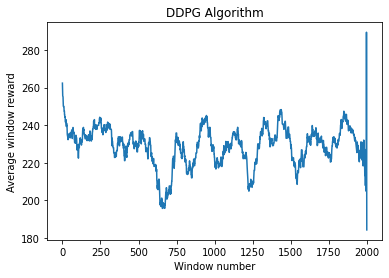

In [16]:
plt.plot(window)
plt.xlabel('Window number')
plt.ylabel('Average window reward')
plt.title('DDPG Algorithm');